# Benchmarks time series forecasting
**Multi-step, multi-output models with weather data**

A comparison between different prediction models

Based on: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
# Choose which feature to predict:
features_out = ["prod_wind", "prod_solar"]

In [2]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
sns.set_theme()
%config InlineBackend.figure_format='retina'

### Import data

In [3]:
# Import electricity and time data
df = pd.read_pickle("..\data\prepared\electricity+time_2017-2021.pkl")

# Features that will be extracted from the wea data and their shorter handle
wx_params = {
    "temperature_air_mean_200": "temp",
    "wind_speed": "wind",
    "pressure_air_site": "press",
    "precipitation_height": "precip",
    "sunshine_duration": "sun"
}

# Concatenate all weather parameters into one data frame
wx_list = []
for name, handle in wx_params.items():
    # wx_list.append(pd.read_pickle("../data/weather/cleaned/"+name+".pkl").add_prefix(handle+"_"))
    wx_list.append(pd.read_pickle("../data/weather/cleaned/"+name+".pkl").add_prefix(handle+"_"))

wx = pd.concat(wx_list, axis=1, ignore_index=False, verify_integrity=True)
df = pd.concat([df, wx], axis=1, ignore_index=False, verify_integrity=True)
df.head()

,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip,temp_00183,temp_00701,...,sun_00856,sun_00953,sun_00963,sun_01443,sun_01605,sun_01694,sun_03032,sun_03231,sun_04104,sun_04177
2017-01-01 00:00:00+00:00,15498.0,0.0,2.504006e-13,1.000000,0.010364,0.999946,-60.908284,0.0,277.45,276.95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:00:00+00:00,15406.9,0.0,2.588190e-01,0.965926,0.011081,0.999939,-56.058615,0.0,277.65,277.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 02:00:00+00:00,14922.3,0.0,5.000000e-01,0.866025,0.011798,0.999930,-48.554986,0.0,277.85,277.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 03:00:00+00:00,15022.0,0.0,7.071068e-01,0.707107,0.012515,0.999922,-39.734647,0.0,277.85,277.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 04:00:00+00:00,15234.0,0.0,8.660254e-01,0.500000,0.013231,0.999912,-30.400744,0.0,277.95,277.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split the data
- 70% training
- 20% validation
- 10% test

In [4]:
n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

num_features = len(features_out)

### Normalize the data

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

### Data Windowing
#### 1. Indexes and offsets

In [6]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=df_train, val_df=df_val, test_df=df_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

##### 2. Split

In [7]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

##### 3. Plot

In [8]:
def plot(self, model=None, plot_col="prod_solar", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=3)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        # Add last point of input array to label and prediction arrays to connect lines
        label_indices_plot = np.insert(
            self.label_indices, 0, self.input_indices[-1])
        labels_plot = np.insert(
            labels[n, :, label_col_index], 0, inputs[n, :, plot_col_index][-1])

        plt.plot(label_indices_plot, labels_plot, 'C2',
                 label='Labels', marker='.', zorder=1)
        if model is not None:
            predictions_plot = (model(inputs))[n, :, label_col_index]
            predictions_plot = np.insert(
                predictions_plot, 0, inputs[n, :, plot_col_index][-1])
            plt.plot(label_indices_plot, predictions_plot,
                     'C1', label='Predictions', marker='.', zorder=2)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


WindowGenerator.plot = plot


#### 4. Create `tf.data.Datasets`

In [9]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [10]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.test` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Multi-step, Multi-output models

- Multi-step models predict multiple time steps in the future
- Multi-output models predict more than one output feature
- The models have the same number of labels and inputs

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35]
Label column name(s): ['prod_wind', 'prod_solar']

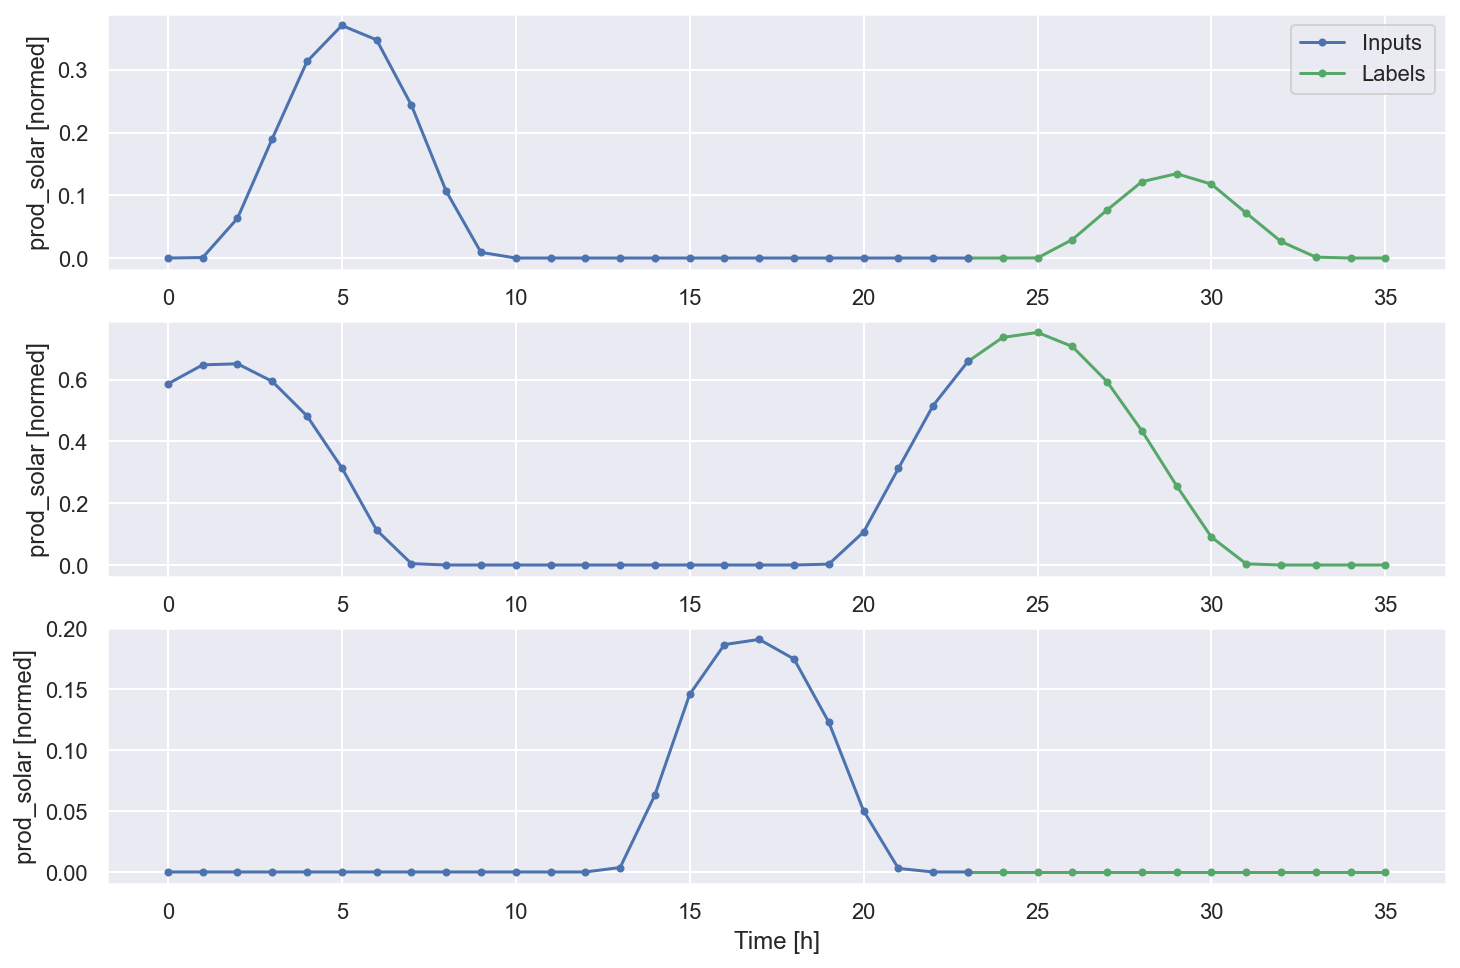

In [11]:
IN_STEPS = 24
OUT_STEPS = 12

multi_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=features_out)

multi_window.plot()
multi_window

In [12]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 68)
Labels shape (batch, time, features): (32, 12, 2)


#### Baseline model: Repeat last step

- repeat last input step for the required number of output time steps
- not trainable

In [13]:
class BaselineRepeatLast(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, 0:2], [1, OUT_STEPS, 1])

273/273 [==============================] - 2s 2ms/step - loss: 0.0565 - mae: 0.1414 - rmse: 0.2377 - r_square: -0.0056


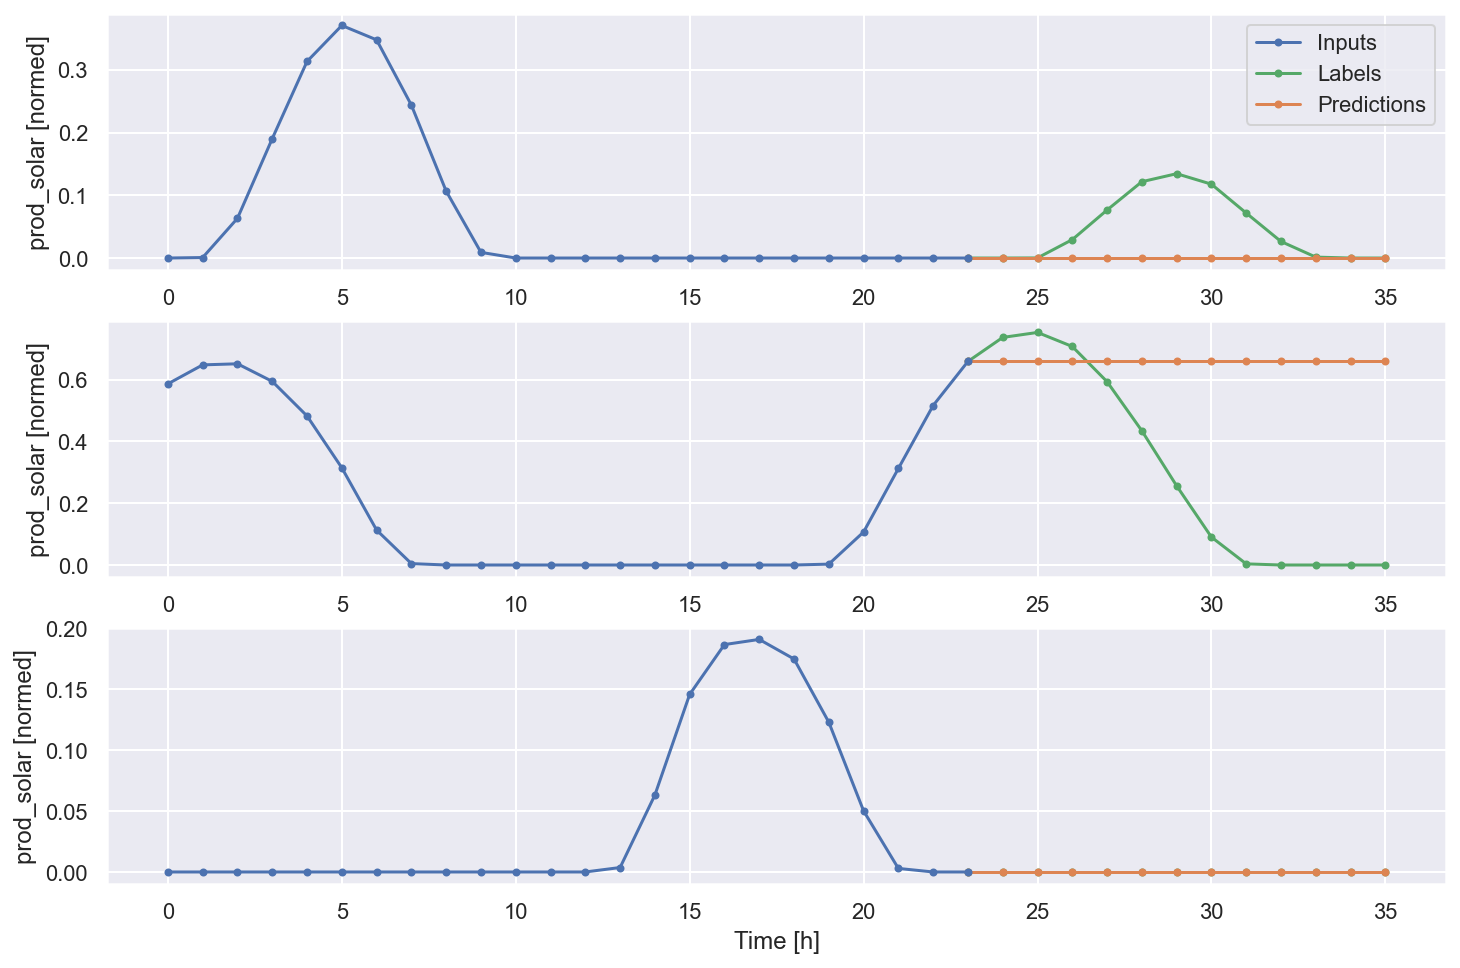

In [14]:
from tensorflow_addons.metrics.r_square import RSquare

baseline_repeat_last = BaselineRepeatLast()
baseline_repeat_last.compile(
    loss='mse', optimizer='adam', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse'), RSquare()])

val_performance = {}
test_performance = {}

val_performance['Repeat last step'] = baseline_repeat_last.evaluate(
    multi_window.val)
test_performance['Repeat last step'] = baseline_repeat_last.evaluate(
    multi_window.test, verbose=0)
multi_window.plot(baseline_repeat_last, plot_col="prod_solar")


#### Baseline model: Same as yesterday

- repeat previous day
- not trainable

273/273 [==============================] - 1s 2ms/step - loss: 0.0238 - mae: 0.0918 - rmse: 0.1543 - r_square: 0.4838


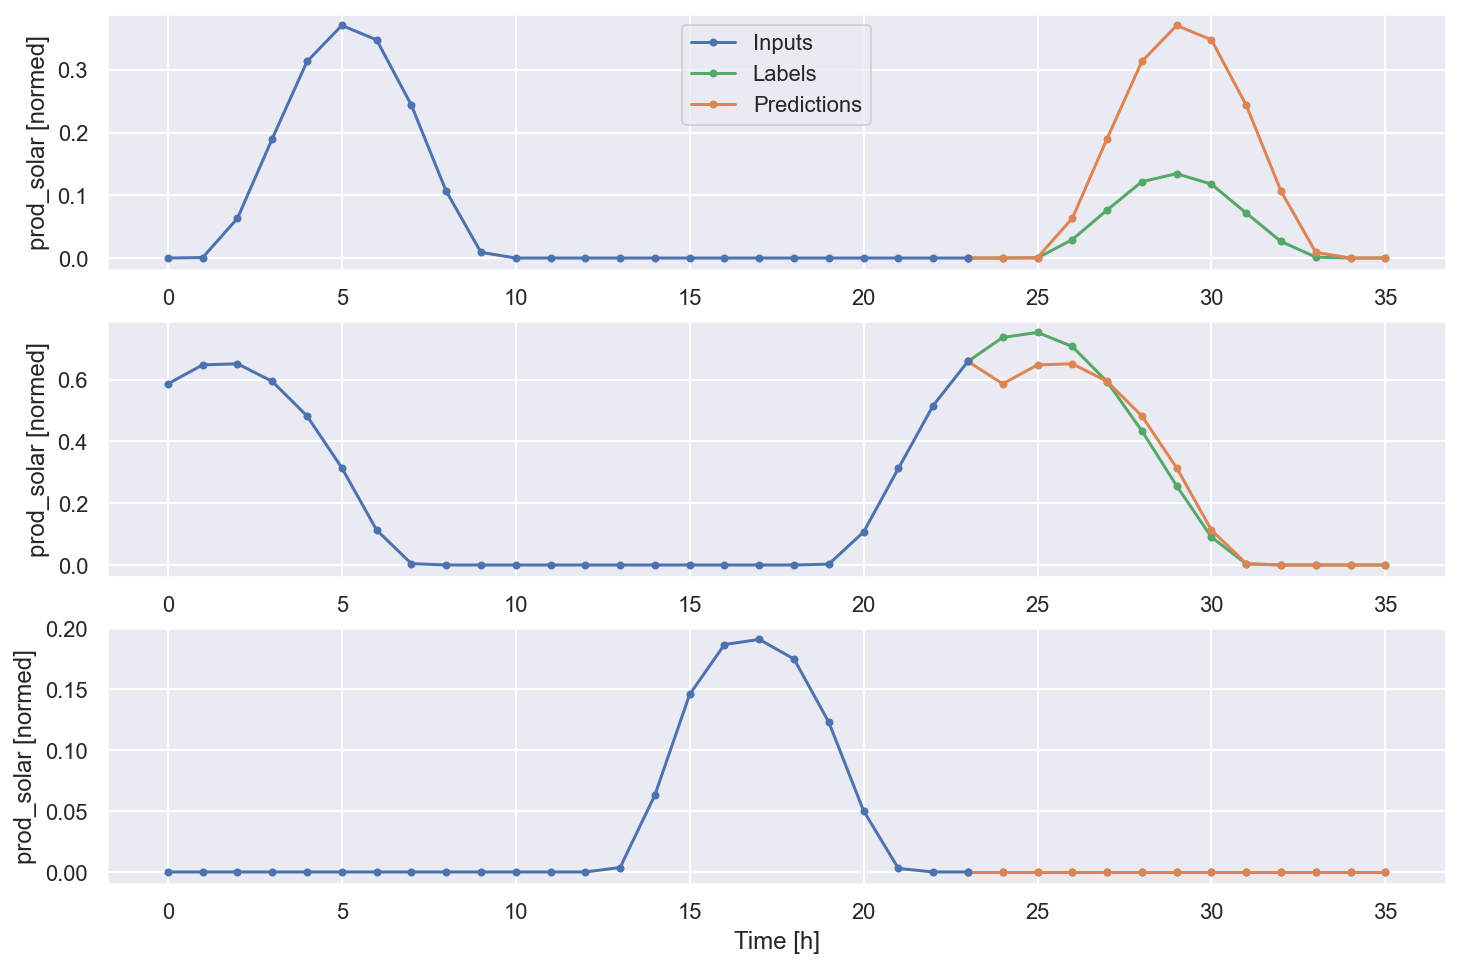

In [15]:
class BaselineYesterday(tf.keras.Model):
    def call(self, inputs):
        return inputs[:, :OUT_STEPS, 0:2]


baseline_yesterday = BaselineYesterday()
baseline_yesterday.compile(
    loss='mse', optimizer='adam', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse'), RSquare()])

val_performance['Repeat yesterday'] = baseline_yesterday.evaluate(
    multi_window.val)
test_performance['Repeat yesterday'] = baseline_yesterday.evaluate(
    multi_window.test, verbose=0)
multi_window.plot(baseline_yesterday)


#### Training procedure
- Used for all trainable models

In [16]:
MAX_EPOCHS = 50


def compile_and_fit(model, window, patience=8):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      verbose=1,
                                                      restore_best_weights=True)

    model.compile(loss='mse', optimizer='adam', metrics=[
                  'mae', tf.keras.metrics.RootMeanSquaredError(name='rmse'), RSquare()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


#### Linear model
- linear transformation
- prediction only depends on one (last) time step

273/273 [==============================] - 1s 2ms/step - loss: 0.0122 - mae: 0.0812 - rmse: 0.1104 - r_square: 0.7662


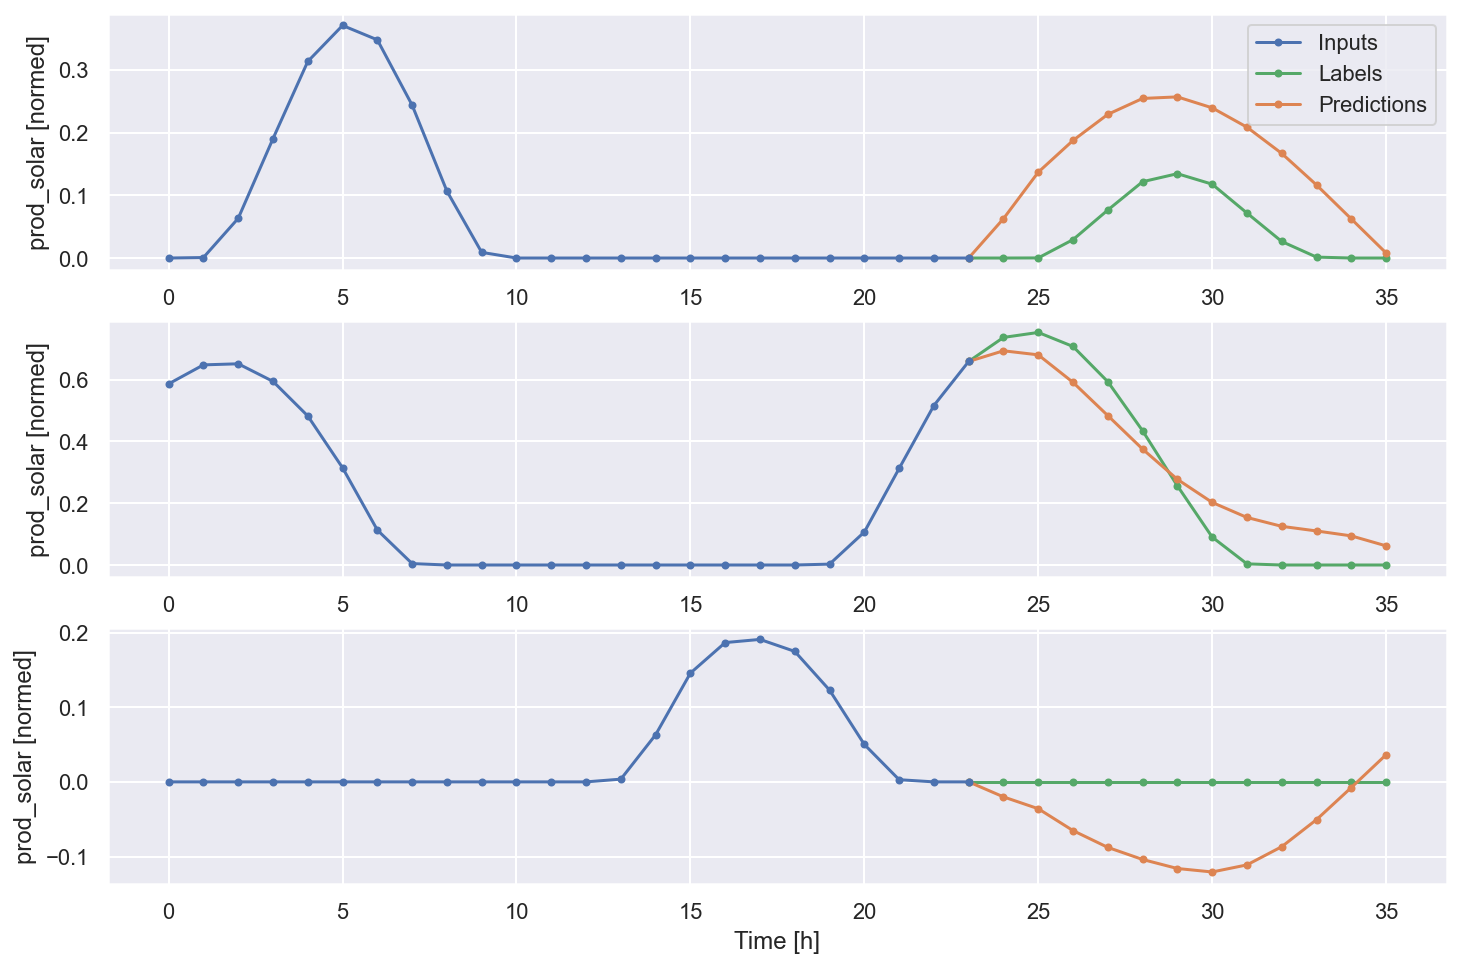

In [17]:
linear = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(linear, multi_window)

IPython.display.clear_output()
val_performance['Linear + wx'] = linear.evaluate(multi_window.val)
test_performance['Linear + wx'] = linear.evaluate(multi_window.test, verbose=0)
multi_window.plot(linear)

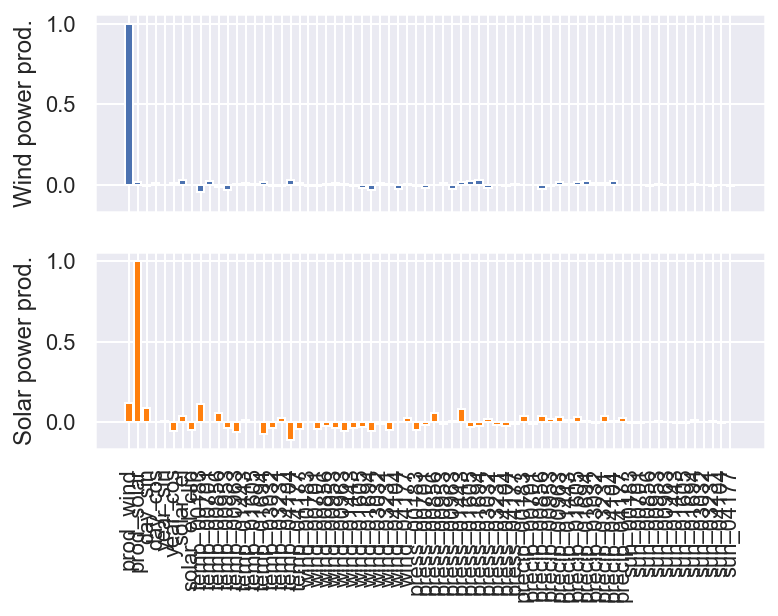

In [18]:
# plot weights
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
axs[0].bar(x = range(len(df_train.columns)),
        height=linear.layers[1].kernel[:,0].numpy())
axs[0].set_ylabel("Wind power prod.")

colors = ['tab:orange'] * num_features
axs[1].bar(x = range(len(df_train.columns)),
        height=linear.layers[1].kernel[:,1].numpy(), color=colors)
axs[1].set_ylabel("Solar power prod.")

axs[1].set_xticks(range(len(df_train.columns)))
_ = axs[1].set_xticklabels(df_train.columns, rotation=90)

#### Dense
- like the `linear` model, but with several stacked `Dense` layers (deep neural network)

273/273 [==============================] - 1s 2ms/step - loss: 0.0058 - mae: 0.0484 - rmse: 0.0764 - r_square: 0.8785


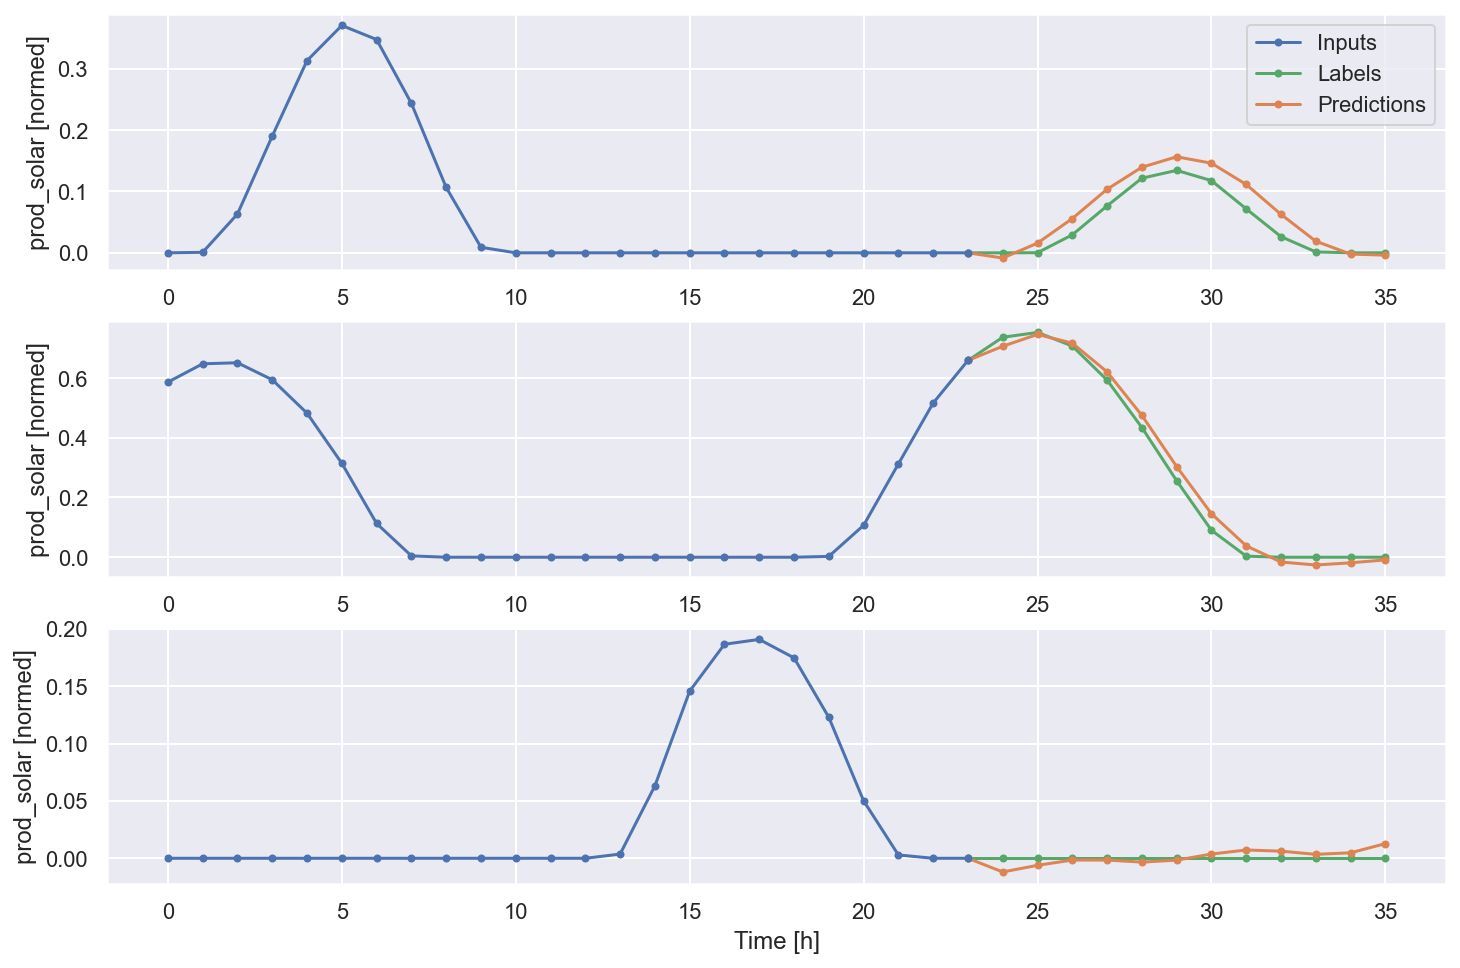

In [19]:
dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(dense_model, multi_window)

IPython.display.clear_output()
val_performance['Dense 512 + wx'] = dense_model.evaluate(multi_window.val)
test_performance['Dense 512 + wx'] = dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(dense_model)

#### CNN (3 inputs)
- Convolutional neural network that predicts one time step into the future based on three time steps

273/273 [==============================] - 1s 2ms/step - loss: 0.0051 - mae: 0.0452 - rmse: 0.0716 - r_square: 0.8931


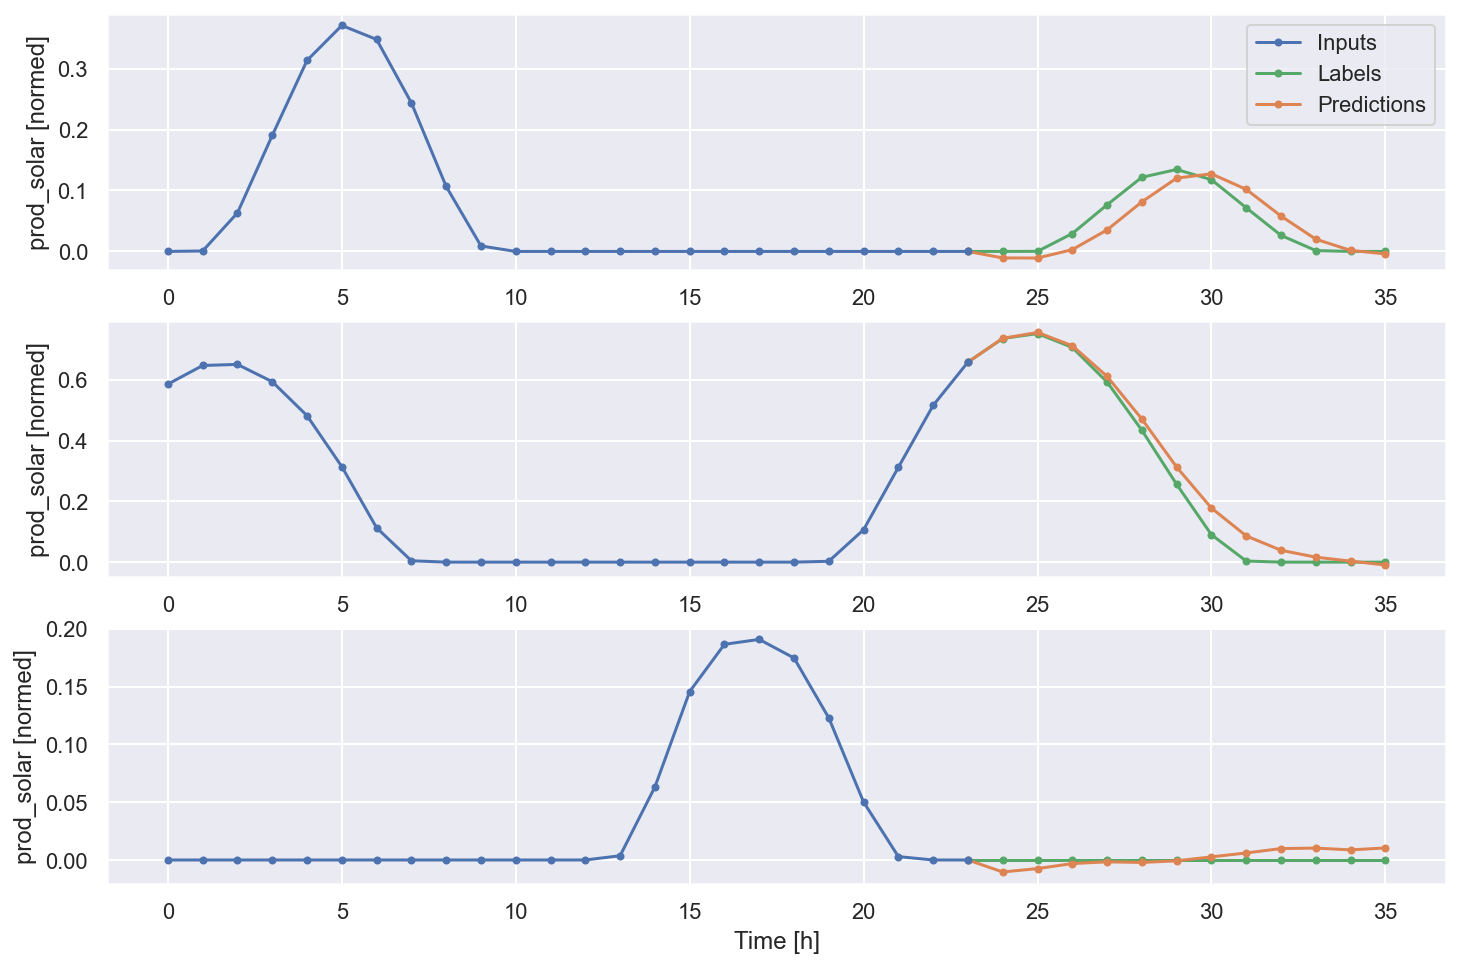

In [20]:
CONV_WIDTH = 3
conv_3_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(conv_3_model, multi_window)

IPython.display.clear_output()

val_performance['CNN 3x256 + wx'] = conv_3_model.evaluate(multi_window.val)
test_performance['CNN 3x256 + wx'] = conv_3_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(conv_3_model)

#### CNN (24 inputs)
- Convolutional neural network that predicts one time step into the future based on 24 time steps

273/273 [==============================] - 1s 2ms/step - loss: 0.0060 - mae: 0.0501 - rmse: 0.0774 - r_square: 0.8739


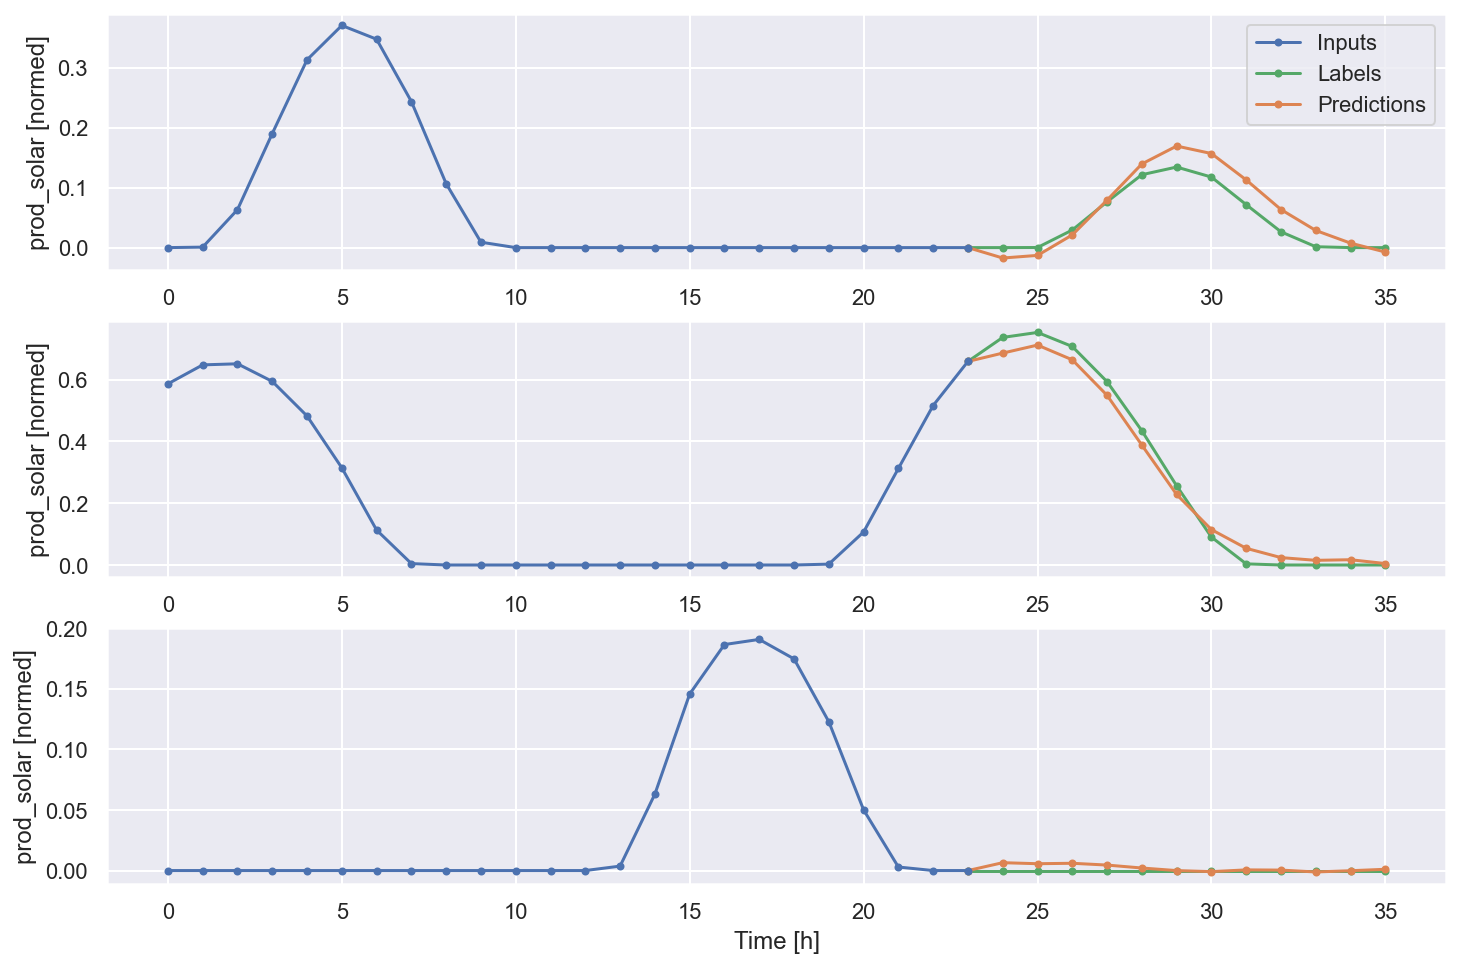

In [21]:
CONV_WIDTH = 24
conv_24_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(conv_24_model, multi_window)

IPython.display.clear_output()

val_performance['CNN 24x256 + wx'] = conv_24_model.evaluate(multi_window.val)
test_performance['CNN 24x256 + wx'] = conv_24_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(conv_24_model)

#### Single-shot Simple RNN
- `return-sequences` is `False`, because the RNN only produces an output (all 24 steps) at the last time step

273/273 [==============================] - 1s 3ms/step - loss: 0.0052 - mae: 0.0463 - rmse: 0.0718 - r_square: 0.8925


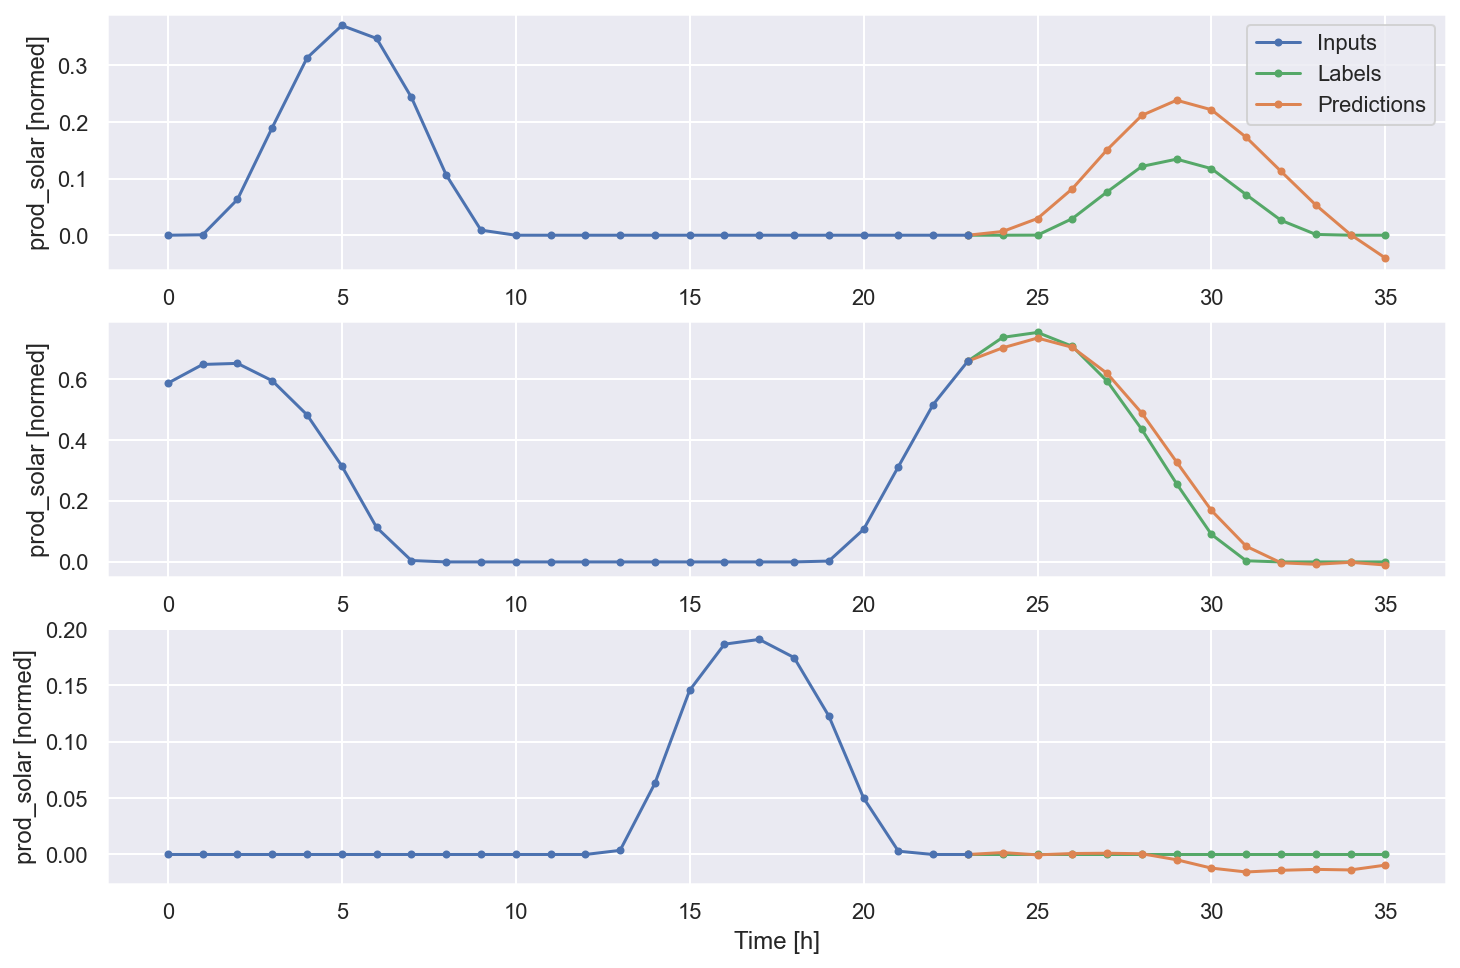

In [22]:
srnn_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, rnn_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.SimpleRNN(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(srnn_model, multi_window)

IPython.display.clear_output()

val_performance['SRNN 32 + wx'] = srnn_model.evaluate(multi_window.val)
test_performance['SRNN 32 + wx'] = srnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(srnn_model)

#### Single-shot GRU

273/273 [==============================] - 1s 2ms/step - loss: 0.0049 - mae: 0.0451 - rmse: 0.0700 - r_square: 0.8985


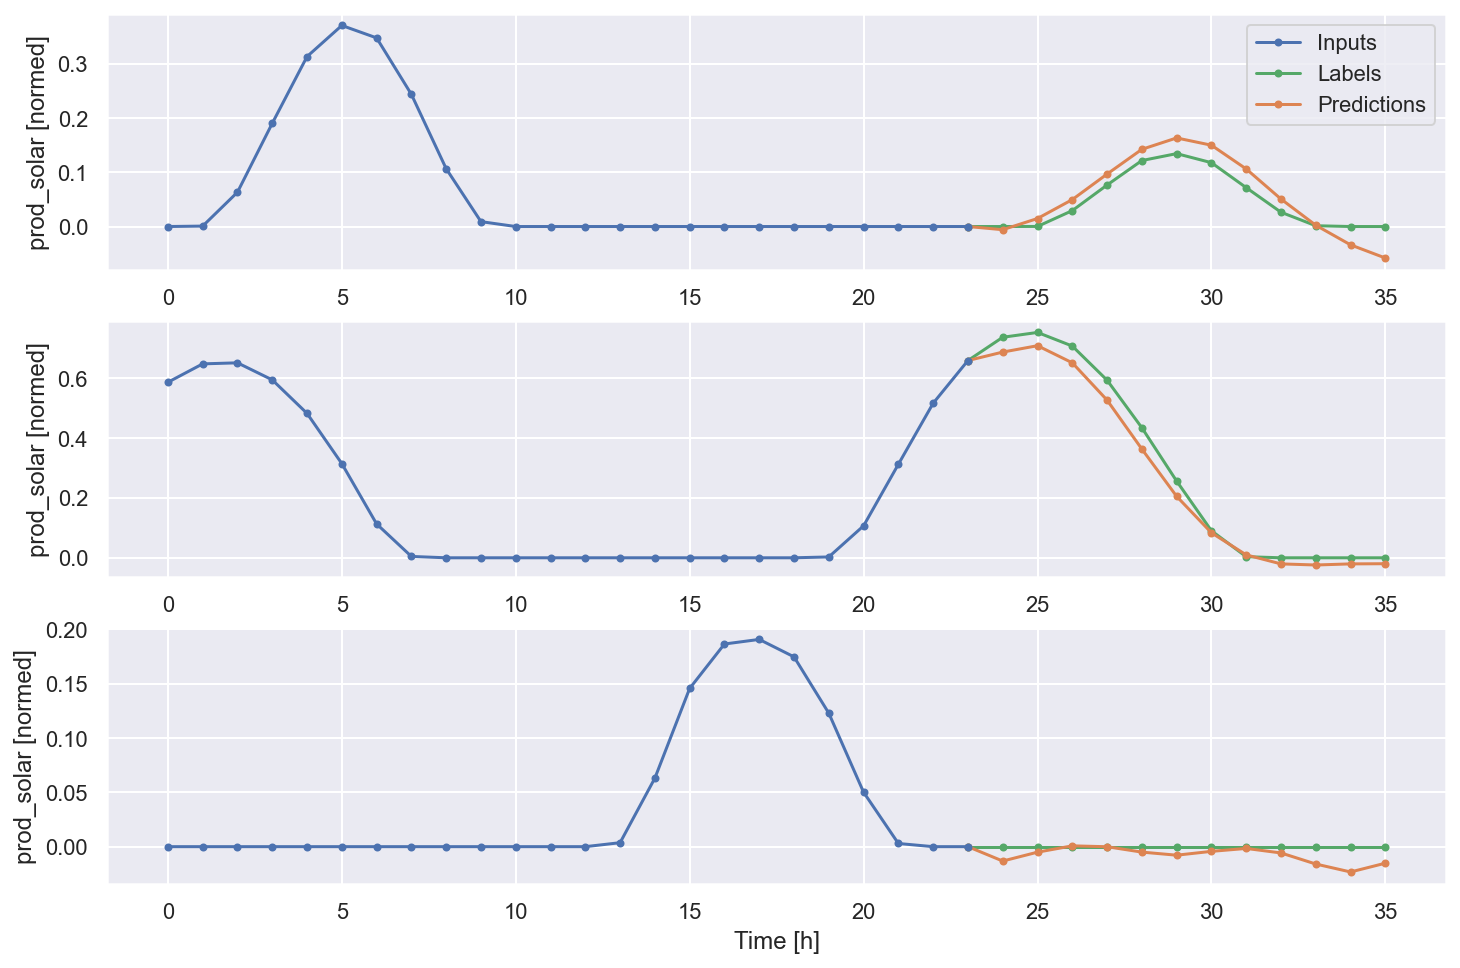

In [23]:
gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(gru_model, multi_window)

IPython.display.clear_output()

val_performance['GRU 32 + wx'] = gru_model.evaluate(multi_window.val)
test_performance['GRU 32 + wx'] = gru_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(gru_model)

#### Single-shot LSTM

273/273 [==============================] - 1s 3ms/step - loss: 0.0051 - mae: 0.0466 - rmse: 0.0716 - r_square: 0.8937


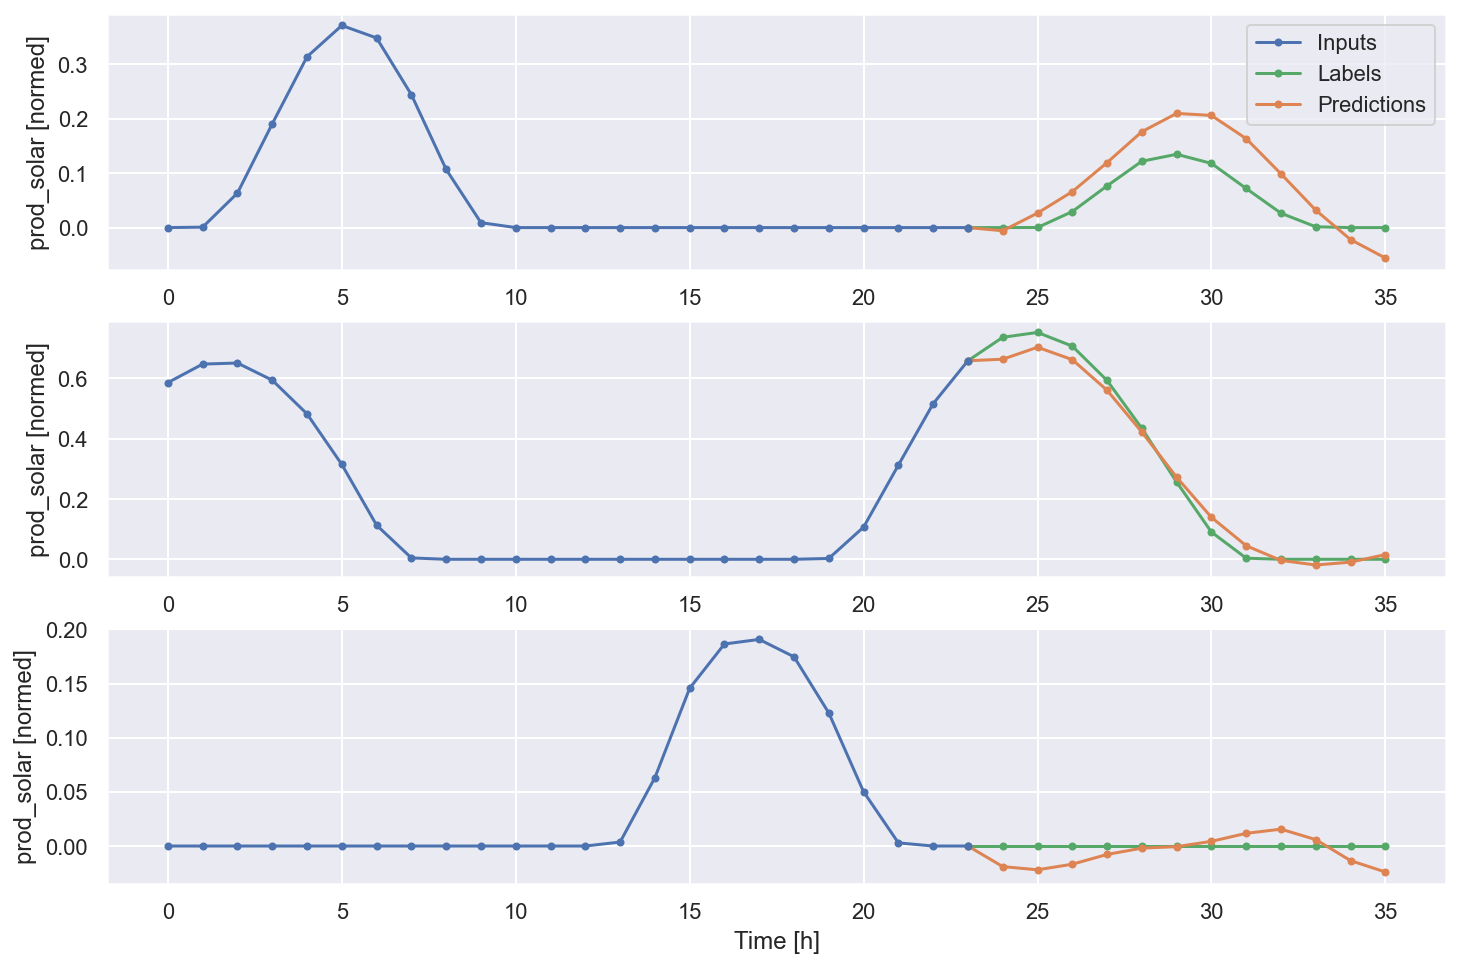

In [24]:
lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(lstm_model, multi_window)

IPython.display.clear_output()

val_performance['LSTM 32 + wx'] = lstm_model.evaluate(multi_window.val)
test_performance['LSTM 32 + wx'] = lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(lstm_model)

#### Single-shot stacked LSTM
- Two stacked LSTM layers

273/273 [==============================] - 1s 4ms/step - loss: 0.0054 - mae: 0.0464 - rmse: 0.0733 - r_square: 0.8892


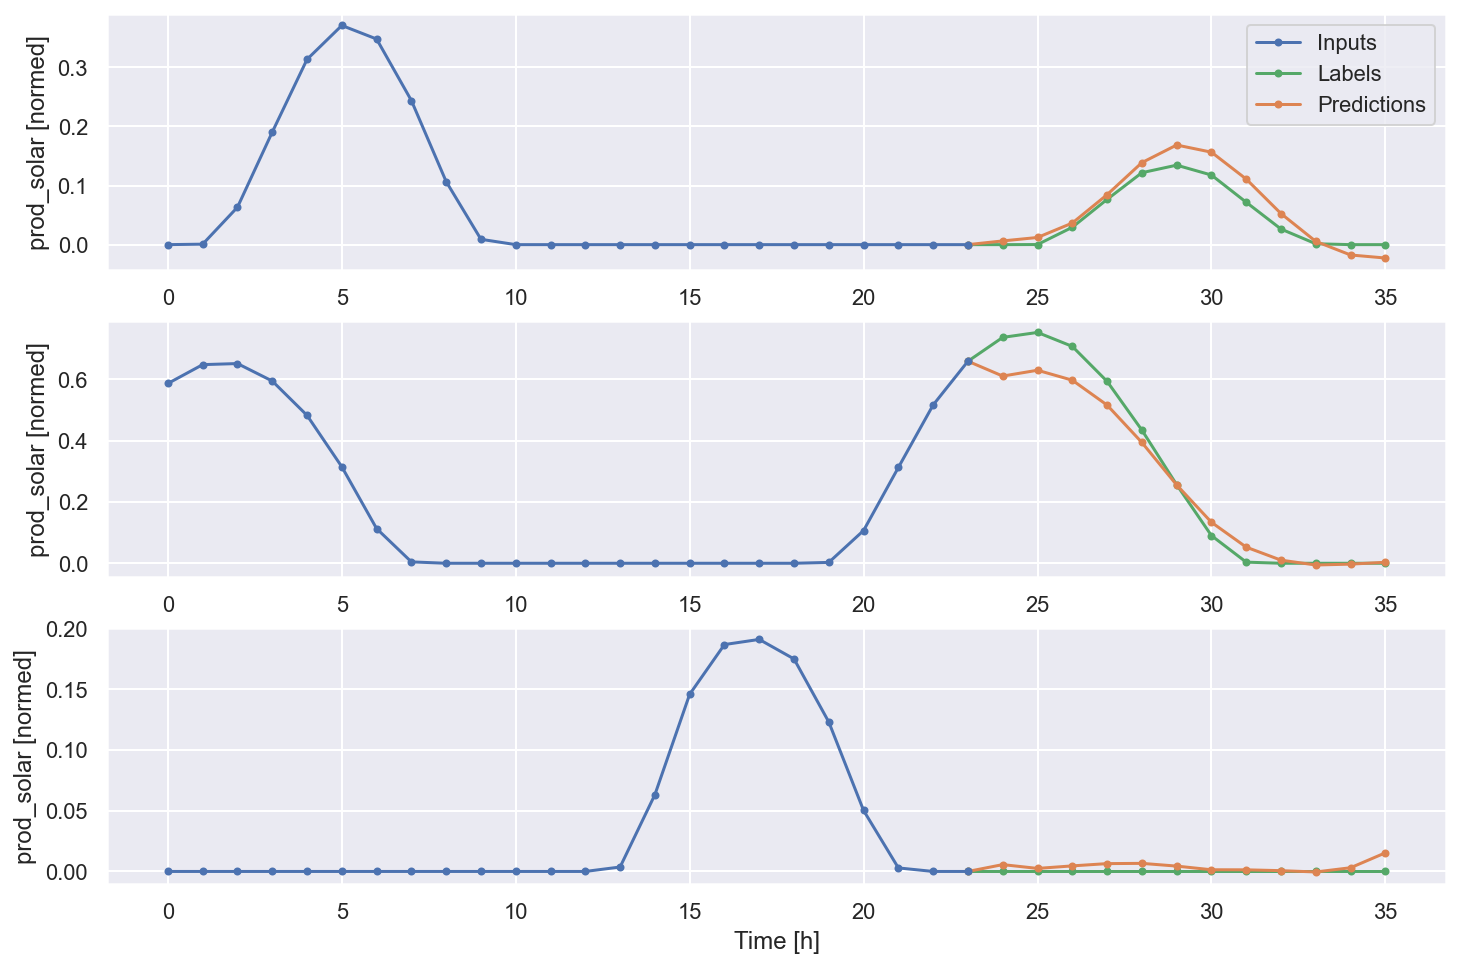

In [25]:
stacked_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(stacked_lstm_model, multi_window)

IPython.display.clear_output()

val_performance['LSTM 32² + wx'] = stacked_lstm_model.evaluate(multi_window.val)
test_performance['LSTM 32² + wx'] = stacked_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(stacked_lstm_model)

### Performance Comparison

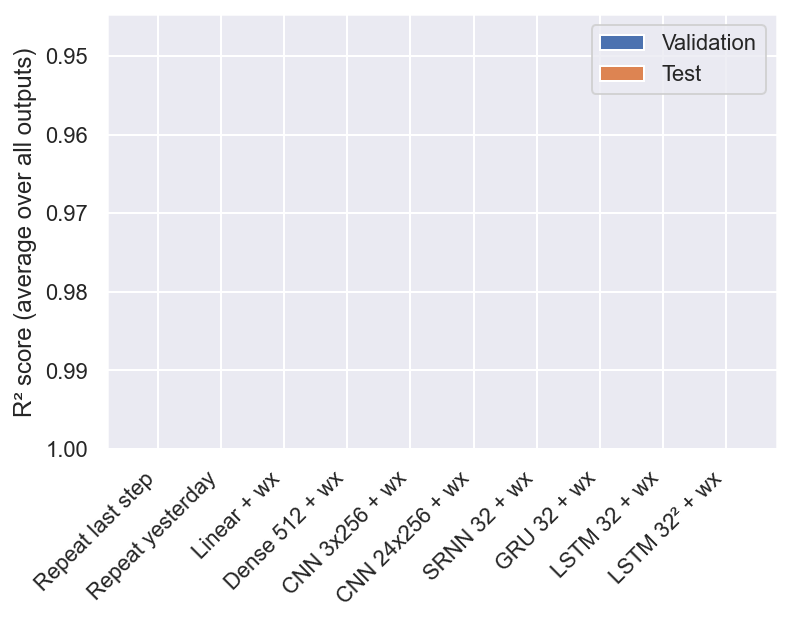

In [26]:
x = np.arange(len(test_performance))
width = 0.3

rmse_index = lstm_model.metrics_names.index('rmse')
r2_index = lstm_model.metrics_names.index('r_square')

val_r2 = [v[r2_index] for v in val_performance.values()]
test_r2 = [v[r2_index] for v in test_performance.values()]

plt.bar(x - 0.17, val_r2, width, label='Validation')
plt.bar(x + 0.17, test_r2, width, label='Test')
plt.xticks(ticks=x, labels=test_performance.keys(),
           rotation=45, ha='right')
plt.ylabel('R² score (average over all outputs)')
plt.ylim(1)
_ = plt.legend()


In [27]:
print(f'{"Model on test set":18s}    RMSE      R²')
print('------------------ ------- -------')
for name, value in test_performance.items():
    print(f'{name+":":18s} {value[rmse_index]: 0.4f} {value[r2_index]: 0.4f}')

Model on test set     RMSE      R²
------------------ ------- -------
Repeat last step:   0.2250 -0.0252
Repeat yesterday:   0.1540  0.4365
Linear + wx:        0.1077  0.7503
Dense 512 + wx:     0.0792  0.8551
CNN 3x256 + wx:     0.0728  0.8773
CNN 24x256 + wx:    0.0807  0.8482
SRNN 32 + wx:       0.0705  0.8854
GRU 32 + wx:        0.0692  0.8904
LSTM 32 + wx:       0.0729  0.8783
LSTM 32² + wx:      0.0714  0.8836
